# Intorduction

In [118]:
# for manipulate data
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.switch_backend('Agg')
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

# for training data
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Overview

In [119]:
# Load dataset
path = r"..\Datasets\car_purchasing.csv"
df = pd.read_csv(path, encoding='latin1')

# Data info
print("Data Informations: ")
df.info()

# Statistic data
print("Statistic data: ")
df.describe(include='all')

# A few rows of data
df.head()

Data Informations: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer name        500 non-null    object 
 1   customer e-mail      500 non-null    object 
 2   country              500 non-null    object 
 3   gender               500 non-null    int64  
 4   age                  500 non-null    float64
 5   annual Salary        500 non-null    float64
 6   credit card debt     500 non-null    float64
 7   net worth            500 non-null    float64
 8   car purchase amount  500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 35.3+ KB
Statistic data: 


,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


# Data cleaning and preprocessing

In [120]:
# Convert data columns to columns should
df['age'] = df['age'].astype(int)

# Grouping cpuntry based on mean target
df['country_encoded'] = df.groupby('country')['car purchase amount'].transform('mean')

# Change target columns to last columns
df = df[['customer name', 'customer e-mail', 'country', 'gender', 'age',
       'annual Salary', 'credit card debt', 'net worth','country_encoded', 'car purchase amount']]
# Check missing values
missing_values = df.isnull().sum()
print(f"Mssing Values :\n{missing_values}")

# Info data
df.info()

Mssing Values :
customer name          0
customer e-mail        0
country                0
gender                 0
age                    0
annual Salary          0
credit card debt       0
net worth              0
country_encoded        0
car purchase amount    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer name        500 non-null    object 
 1   customer e-mail      500 non-null    object 
 2   country              500 non-null    object 
 3   gender               500 non-null    int64  
 4   age                  500 non-null    int64  
 5   annual Salary        500 non-null    float64
 6   credit card debt     500 non-null    float64
 7   net worth            500 non-null    float64
 8   country_encoded      500 non-null    float64
 9   car purchase amount  500 non-null    float64
dtypes: float64(

<Figure size 1200x800 with 0 Axes>

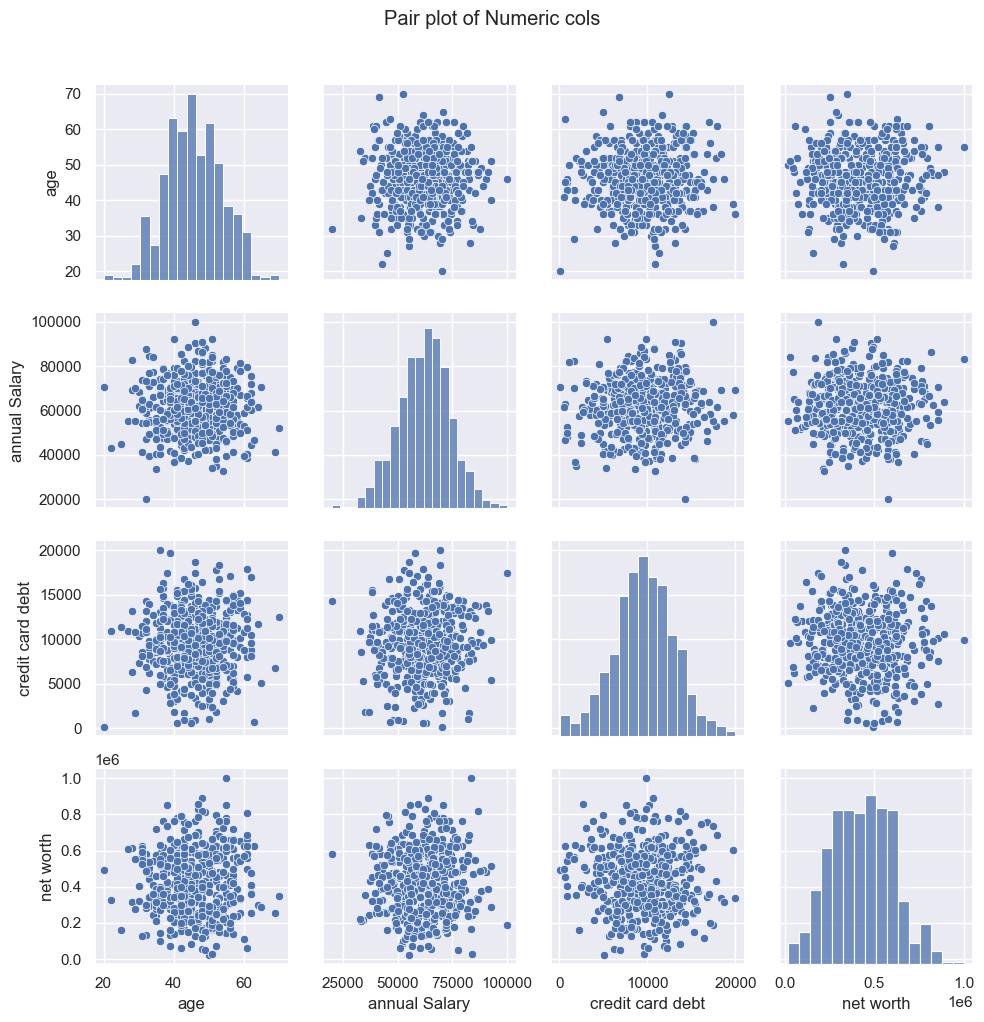

In [121]:
# Pair Plot for numeric columns
numeric_cols = df.iloc[:, 4:-2].columns
plt.figure(figsize=(12, 8))
sns.pairplot(df[numeric_cols]).fig.suptitle('Pair plot of Numeric cols', y=1.02)
plt.tight_layout()
plt.show()

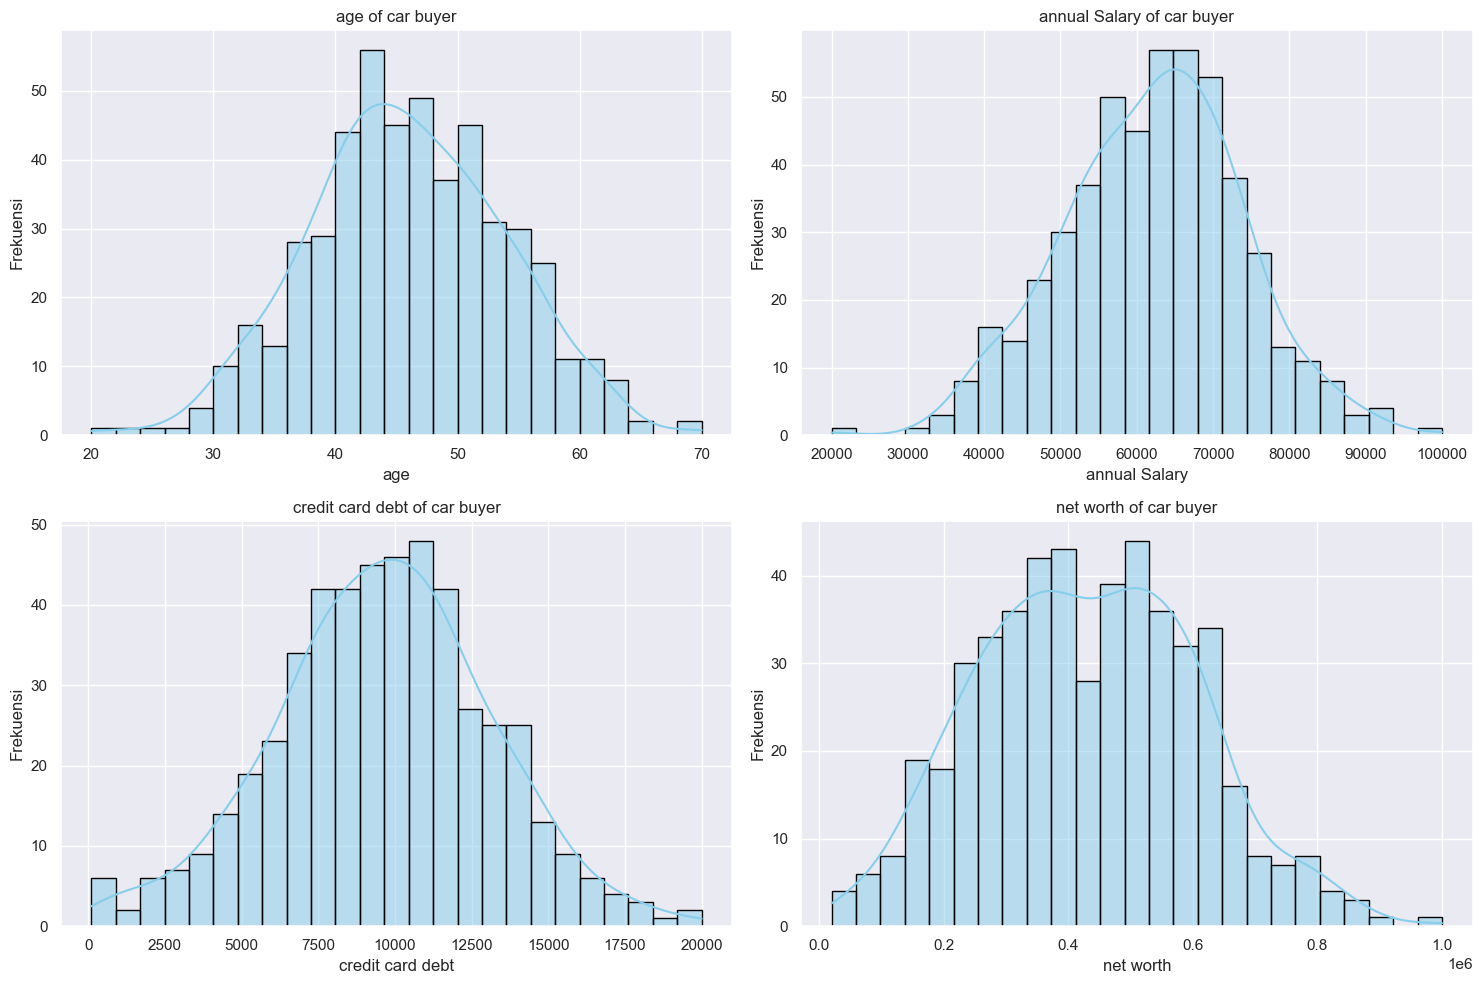

In [122]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, len(numeric_cols) - 2, i+1)
    sns.histplot(df[col], kde=True,bins=25,edgecolor='black', color='skyblue')
    plt.title(f'{col} of car buyer')
    plt.xlabel(f'{col}')
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

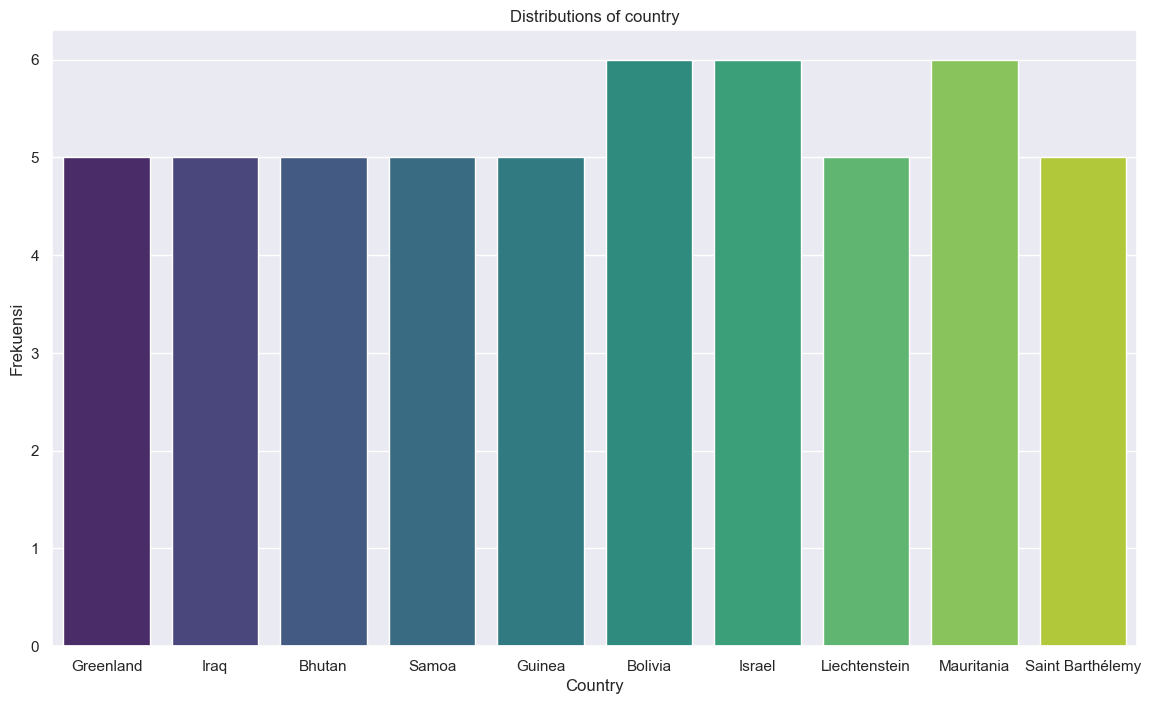

In [123]:
# Plot 'gender' to see Gender distributions
top_country = df['country'].value_counts().nlargest(10).index
plt.figure(figsize=(14, 8))
sns.countplot(data=df[df['country'].isin(top_country)], x='country', palette='viridis')
plt.title(f'Distributions of country')
plt.xlabel(f'Country')
plt.ylabel('Frekuensi')
plt.show()

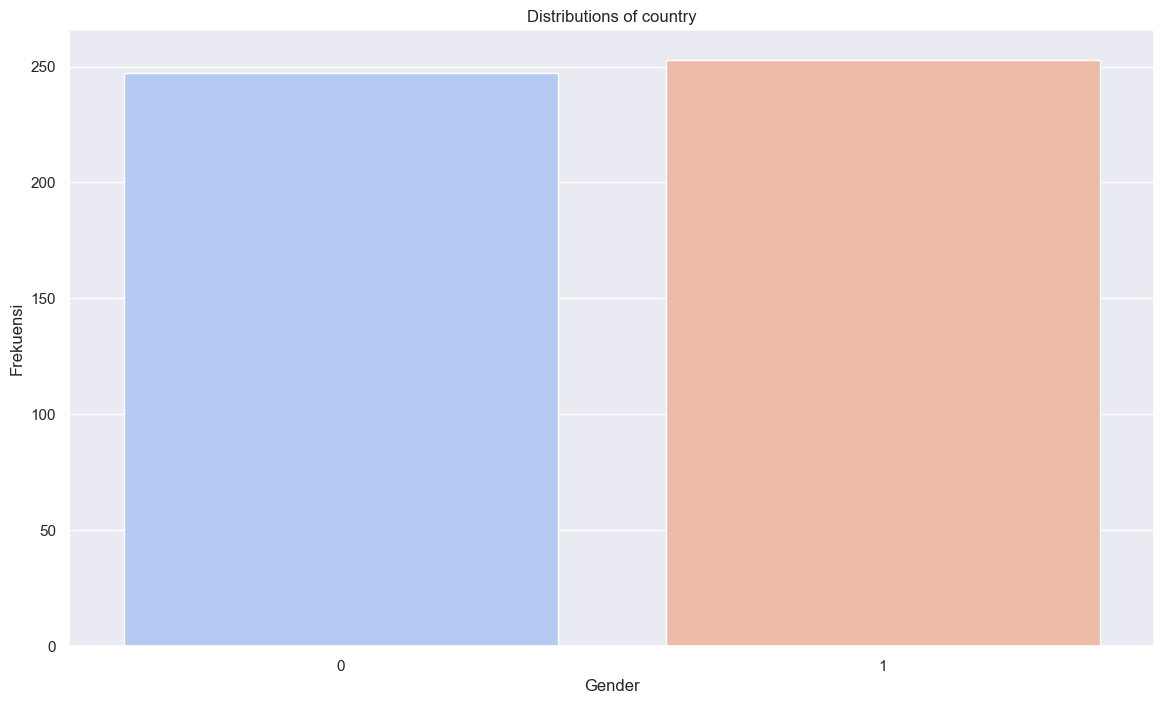

In [124]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='gender', palette='coolwarm')
plt.title(f'Distributions of country')
plt.xlabel(f'Gender')
plt.ylabel('Frekuensi')
plt.show()

# Training the Model

In [125]:
# Choose features and target
numeric_cols = df.select_dtypes(include='number').drop('car purchase amount', axis=1).columns
X = df.iloc[:, 3:-1]
y = df.iloc[:, -1]

# Spliiting the data into train and test set
print(f"Length of Record : {len(df)}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data
me = MinMaxScaler()
sc = StandardScaler()
print("Scaling data for lighten up computation")
for i, col in enumerate(numeric_cols):
    if col in ['age','gender']:
        X_train[col] = me.fit_transform(X_train[[col]])
        X_test[col] = me.transform(X_test[[col]])
    else:
        X_train[col] = sc.fit_transform(X_train[[col]])
        X_test[col] = sc.transform(X_test[[col]])

# Convert to numpy array
X = X.values
y = y.values
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

Length of Record : 500
Scaling data for lighten up computation


Train Random Forest with best Hyperparameters tuning and learning curve
Random Forest | R2=0.928 | RMSE=2787.267 | MAE=2148.937


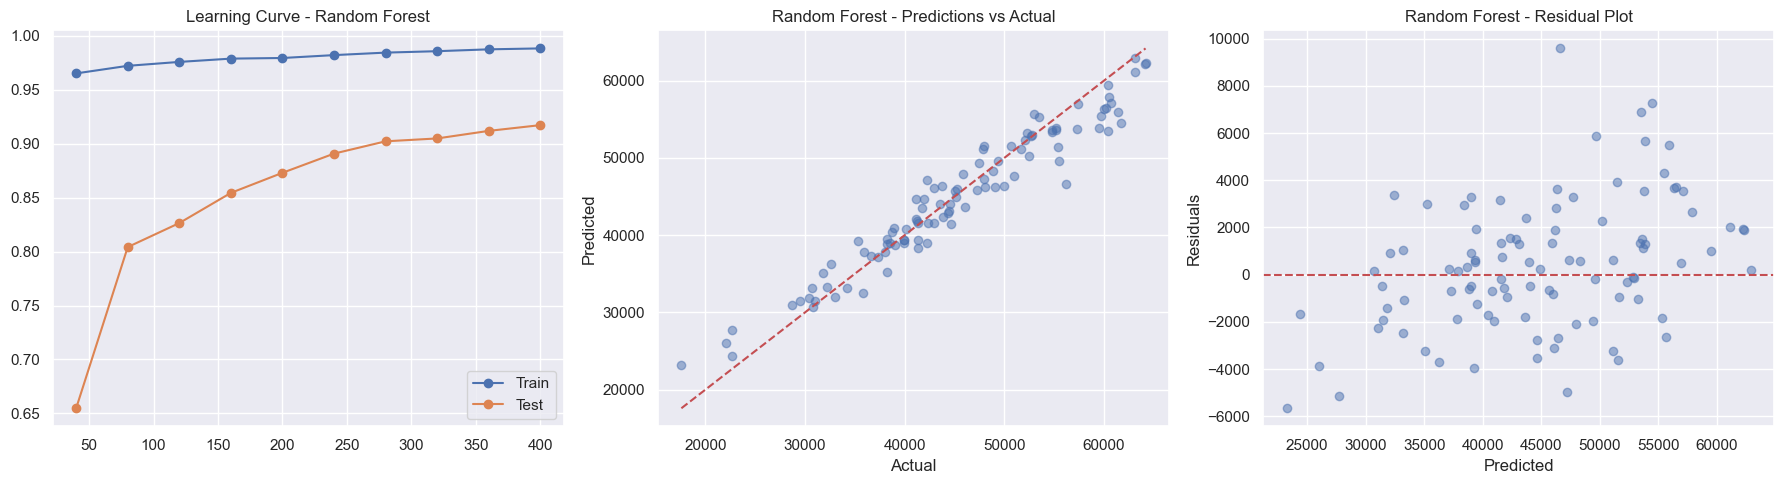

Train XGBoost with best Hyperparameters tuning and learning curve
XGBoost | R2=0.988 | RMSE=1153.282 | MAE=845.873


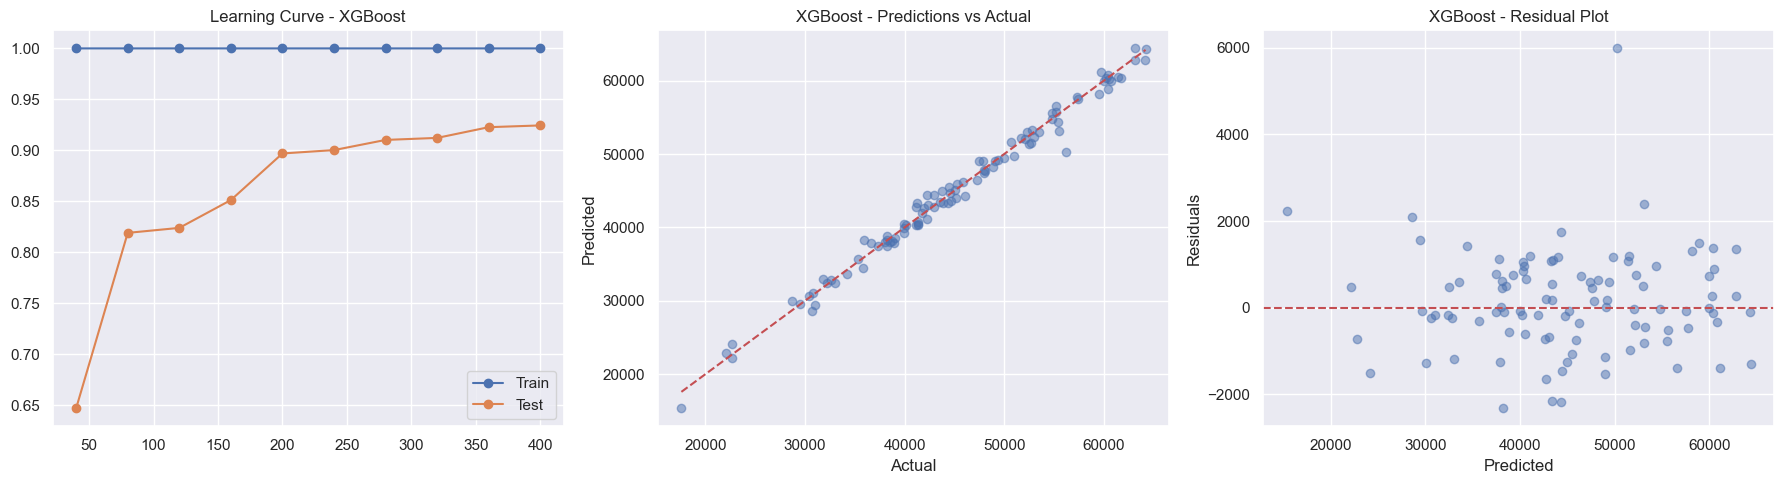

In [126]:
# Inisialisasi model
regressor = {
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),
    'XGBoost': XGBRegressor()
}
# parameter each model
param_grid = {
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [None, 5, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    },

    'XGBoost': {
        'n_estimators': [100, 200, 300, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.5, 0.7, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0.5, 1, 1.5, 2]
    }
}

# Select k-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for i, (name, model) in enumerate(regressor.items(), start=0):
    print(f"Train {name} with best Hyperparameters tuning and learning curve")
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid[name],
        cv=kf,
        scoring='r2',
        n_iter=20,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Metrics
    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MAE = mean_absolute_error(y_test, y_pred)
    print(f"{name} | R2={R2:.3f} | RMSE={RMSE:.3f} | MAE={MAE:.3f}")

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=kf, scoring='r2', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Learning curve
    axs[0].plot(train_sizes, train_mean, 'o-', label='Train')
    axs[0].plot(train_sizes, test_mean, 'o-', label='Test')
    axs[0].set_title(f'Learning Curve - {name}')
    axs[0].legend(); axs[0].grid(True)

    # Actual vs Predicted
    axs[1].scatter(y_test, y_pred, alpha=0.5)
    axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axs[1].set_title(f'{name} - Predictions vs Actual')
    axs[1].set_xlabel('Actual'); axs[1].set_ylabel('Predicted')

    # Residual Plot
    residuals = y_test - y_pred
    axs[2].scatter(y_pred, residuals, alpha=0.5)
    axs[2].axhline(y=0, color='r', linestyle='--')
    axs[2].set_title(f'{name} - Residual Plot')
    axs[2].set_xlabel('Predicted'); axs[2].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()